# Panan01 salinity

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34577/status,
Dashboard: /proxy/34577/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41047,Workers: 28
Dashboard: /proxy/34577/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:37211,Total threads: 1
Dashboard: /proxy/35197/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:45765,


2025-09-21 15:57:38,396 - distributed.nanny - WARNING - Restarting worker
2025-09-21 15:57:38,432 - distributed.nanny - WARNING - Restarting worker
2025-09-21 15:57:38,456 - distributed.nanny - WARNING - Restarting worker
2025-09-21 15:57:38,534 - distributed.nanny - WARNING - Restarting worker
2025-09-21 15:57:38,569 - distributed.nanny - WARNING - Restarting worker
2025-09-21 15:57:38,718 - distributed.nanny - WARNING - Restarting worker
2025-09-21 15:57:38,739 - distributed.nanny - WARNING - Restarting worker
2025-09-21 15:57:38,793 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:43381' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('array-3af8f211080b70ae43e6900a1f410d9c', 0, 0)} (stimulus_id='handle-worker-cleanup-1758434258.7933757')
2025-09-21 15:57:38,826 - distributed.nanny - WARNING - Restarting worker
2025-09-21 15:57:38,829 - distributed.nanny - WARNING - Restarting worker
2025-09-21 15:57:38,919 - distributed

In [4]:
# Importing data

pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [5]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')

In [7]:
#Time variant variables
def preprocess(ds):
    ds = ds[['so', 'volcello']].isel(z_l=0).sel(yh=slice(None,-55))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [9]:
# Area
areaC = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output020/20010101.ocean_static.nc')['areacello']

In [10]:
# Salinity variable
saltC = cont['so']
saltM = melt['so']

In [11]:
# Correcting area
var_C = saltC.isel(time=0)
var_M = saltM.isel(time=0)

areaC_corr = areaC*(var_C*0 +1)
areaM_corr = areaM*(var_M*0 +1)

[gadi-cpu-bdw-0056:1123034:0:1123034] Caught signal 7 (Bus error: nonexistent physical address)
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Ca

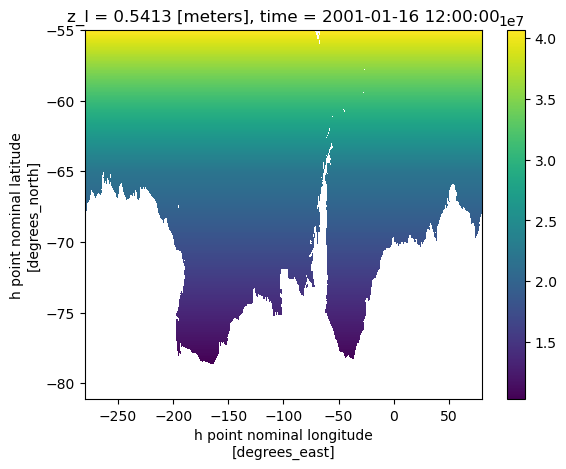

In [12]:
areaC_corr.plot()

## Surface salinity

In [13]:
shelf_salt_cont = saltC.where(shelf_mask == 1)
shelf_salt_pert = saltM.where(shelf_mask == 1)
shelf_salt_cont

<xarray.DataArray 'so' (time: 120, yh: 533, xh: 3600)> Size: 921MB
dask.array<where, shape=(120, 533, 3600), dtype=float32, chunksize=(2, 194, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.0 -78.95 -78.91 ... -55.18 -55.12 -55.07
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
    z_l      float64 8B 0.5413
Attributes:
    units:          psu
    long_name:      Sea Water Salinity
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

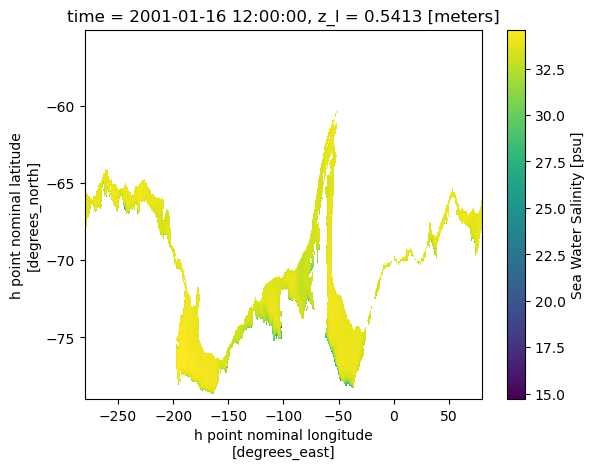

In [14]:
shelf_salt_cont.isel(time=0).plot()

#### time series

In [18]:
# Spatial average
topsalt_cont_time = (areaC_corr * shelf_salt_cont).sum(['xh', 'yh']) / areaC_corr.where(shelf_mask == 1).sum(['xh', 'yh'])
topsalt_pert_time = (areaM_corr * shelf_salt_pert).sum(['xh', 'yh']) / areaM_corr.where(shelf_mask == 1).sum(['xh', 'yh'])

In [19]:
topsalt_cont_time

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
    z_l      float64 8B 0.5413
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00

In [20]:
topsalt_cont_time = topsalt_cont_time.load()

In [21]:
topsalt_pert_time = topsalt_pert_time.load()

Text(0.5, 1.0, 'Pan01 Time Series of Surface Salinity on Shelf')

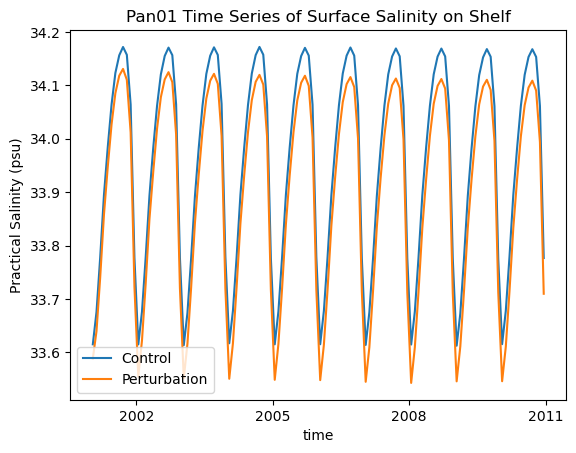

In [22]:
topsalt_cont_time.plot(label="Control")
topsalt_pert_time.plot(label="Perturbation")
#plt.xlim(380,4000)
#plt.ylim(-1.30,-0.70)
plt.ylabel("Practical Salinity (psu)")
plt.legend(loc="lower left")
plt.title("Pan01 Time Series of Surface Salinity on Shelf")

In [24]:
topsalt_anom_time = topsalt_pert_time - topsalt_cont_time
topsalt_anom_time = topsalt_anom_time.load()

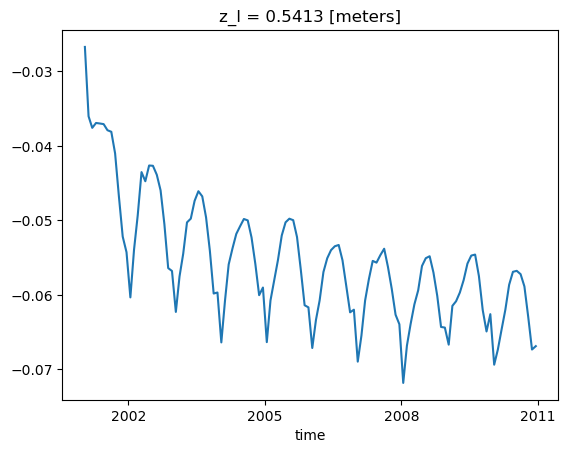

In [25]:
topsalt_anom_time.plot()

In [26]:
topsalt_anom_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/topsalt_anom_pan01.nc')

#### Mapping bottom salinity

In [15]:
saltC_map = saltC.sel(time=slice('2006-01-01','2010-12-31'))
saltM_map = saltM.sel(time=slice('2006-01-01','2010-12-31'))

In [16]:
saltC_map

<xarray.DataArray 'so' (time: 60, yh: 584, xh: 3600)> Size: 505MB
dask.array<getitem, shape=(60, 584, 3600), dtype=float32, chunksize=(2, 242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 5kB -81.11 -81.07 -81.02 ... -55.12 -55.07 -55.01
    z_l      float64 8B 0.5413
  * time     (time) object 480B 2006-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          psu
    long_name:      Sea Water Salinity
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

In [17]:
topsalt_cont_map = saltC_map.mean(dim='time')
topsalt_pert_map = saltM_map.mean(dim='time')
topsalt_anom_map = topsalt_pert_map - topsalt_cont_map

In [18]:
topsalt_anom_map = topsalt_anom_map.load()

In [21]:
topsalt_anom_map.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surface_salinity_map_Pan01.nc')

In [17]:
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
projection = ccrs.SouthPolarStereo()

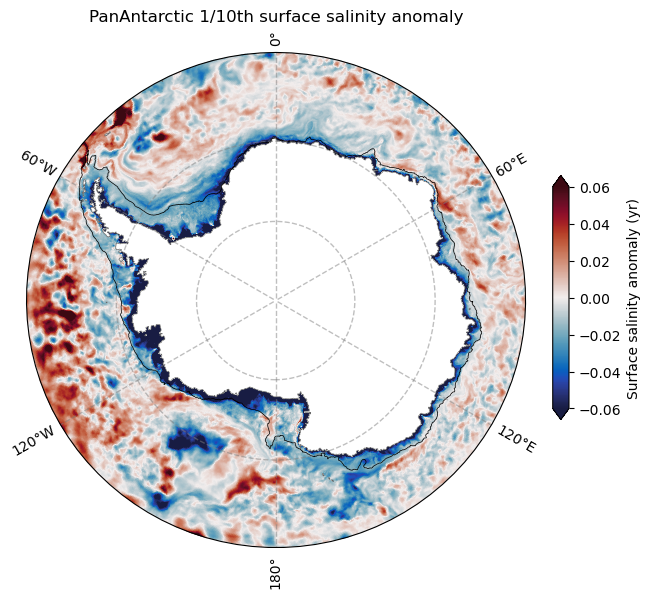

In [18]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
topsalt_anom_map.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.06,
    vmax=0.06,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Surface salinity anomaly (yr)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("PanAntarctic 1/10th surface salinity anomaly");

In [25]:
# Create a mask: True where depth is greater (deeper) than 3000m (or less if bathy is negative)
mask_3000m = depth > 3500  # or bathy < -3000 depending on bathy convention (usually negative)

# Mask your data array (abs_anom) where bathy is deeper than 3000m
import numpy as np
topsalt_anom_map_masked = topsalt_anom_map.where(~mask_3000m).fillna(0)  # keep data only shallower or equal to 3000m

Text(0.5, 1.0, '')

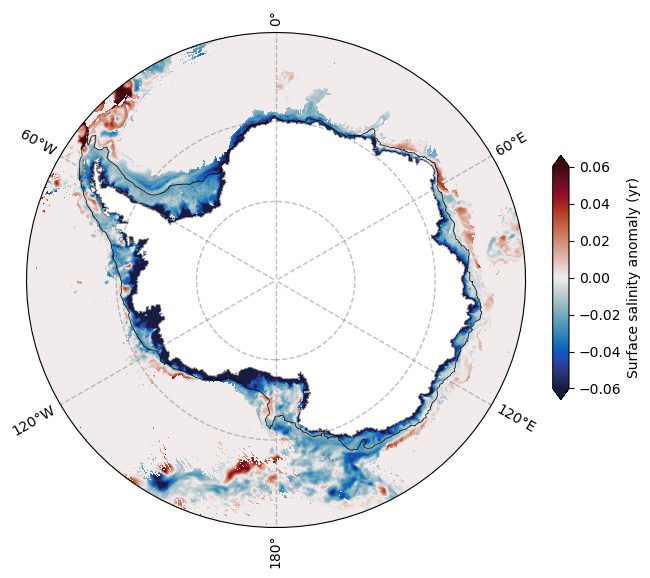

In [26]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
topsalt_anom_map_masked.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.06,
    vmax=0.06,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Surface salinity anomaly (yr)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);


plt.title('')
#plt.title("PanAntarctic 1/10th surface salinity anomaly");